In [1]:
import pandas as pd
import matplotlib.pyplot as plt

path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8', index_col=[0])

list(data.columns)

['publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

In [2]:
import numpy as np
import matplotlib.pyplot as plt

embeddings = np.load('youtube_comments_climate_change/embeddings_transformer.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

### To load embeddings into embeddings projector

In [102]:
#np.savetxt("embeddings.tsv", embeddings, delimiter="\t")

In [17]:
import csv

data_to_csv = data[['text', 'label_kmedoids', 'labels_agglomerative']].copy()

for i, row in data_to_csv.iterrows():
    if "\n" in data_to_csv['text'][i]:
        text = data_to_csv['text'][i]
        data_to_csv.at[i,'text'] = text.replace("\n", " ")

pd.DataFrame(data_to_csv).to_csv('metadata.tsv',sep='\t', quoting=csv.QUOTE_NONE, index=True)

In [4]:
import umap

n_neighbors = 30
min_dist = 0.1
n_components = 100
metric = 'cosine'

reduced_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(embeddings)

In [5]:
#np.save('reduced_umap_100.npy', reduced_embeddings, allow_pickle=True, fix_imports=True)

In [3]:
reduced_embeddings = np.load('youtube_comments_climate_change/reduced_umap_100.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

sc = StandardScaler()
scaled_embeddings = sc.fit_transform(normalize(reduced_embeddings, norm='l2'))

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

def cos_sim(input_vectors):
    similarity = cosine_distances(input_vectors)
    return similarity

cosine_similarity_matrix = cos_sim(np.array(reduced_embeddings))
print(cosine_similarity_matrix)

[[0.0000000e+00 4.3067336e-03 2.0281076e-03 ... 4.8039556e-03
  2.5195479e-03 1.4227629e-04]
 [4.3067336e-03 0.0000000e+00 3.3246279e-03 ... 1.6093254e-05
  4.9554110e-03 4.0265322e-03]
 [2.0281076e-03 3.3246279e-03 0.0000000e+00 ... 3.6975741e-03
  1.6142130e-03 1.8213391e-03]
 ...
 [4.8039556e-03 1.6093254e-05 3.6975741e-03 ... 0.0000000e+00
  5.4633617e-03 4.5250058e-03]
 [2.5195479e-03 4.9554110e-03 1.6142130e-03 ... 5.4633617e-03
  0.0000000e+00 1.7789006e-03]
 [1.4227629e-04 4.0265322e-03 1.8213391e-03 ... 4.5250058e-03
  1.7789006e-03 0.0000000e+00]]


In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=100) # results remain roughly the same with n_neighbors<100
nbrs = neigh.fit(cosine_similarity_matrix)
distances, indices = nbrs.kneighbors(cosine_similarity_matrix)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [57]:
import math

def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i,0] - X[j,0]) ** 2) +
                    ((X[i,1] - X[j,1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

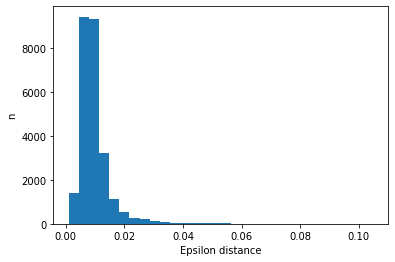

In [58]:
eps_dist = calculate_kn_distance(cosine_similarity_matrix,5)
plt.hist(eps_dist,bins=30)
plt.ylabel('n');
plt.xlabel('Epsilon distance');

In data set, majority of points lie within 0.6 units from their 5th nearest neighbor. A heuristic approach could be choosing 0.6 as DBSCAN epsilon (HDBSCAN cluster_selection_epsilon) parameter.

## KMedoids

param max_iter hab ich schon mal getuned

In [11]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score


# check silhouette score with umap directly reduced to 2 dimension
kmedoids_clustering = KMedoids(
    n_clusters=9,
    max_iter=100,
    init='k-medoids++', random_state=1234
).fit(reduced_embeddings)
kmedoids_labels = kmedoids_clustering.labels_
kmedoids_silhouette = silhouette_score(reduced_embeddings, kmedoids_labels)

In [23]:
kmedoids_silhouette

0.33582336

In [84]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score

kmedoids_inertia, kmedoids_silhouette, kmedoids_freq = {}, {}, {}
init_param = 'k-medoids++'
random_state_param=1234
for i in range(2,21):
    kmedoids_clustering = KMedoids(n_clusters=i, metric='cosine', max_iter=100, init=init_param, random_state=random_state_param).fit(reduced_embeddings)
    kmedoids_inertia[i] = kmedoids_clustering.inertia_
    kmedoids_labels = kmedoids_clustering.labels_
    kmedoids_silhouette[i] = silhouette_score(reduced_embeddings, kmedoids_labels)
    (unique, counts) = np.unique(kmedoids_labels, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    kmedoids_freq[i] = frequencies[frequencies[:,0].argsort()]
    print("n_iterations: {} inertia: {} silhouette score: {}".format(i, kmedoids_inertia[i], kmedoids_silhouette[i]))

n_iterations: 2 inertia: 30.865163803100586 silhouette score: 0.7484121322631836
n_iterations: 3 inertia: 18.080448150634766 silhouette score: 0.3772909343242645
n_iterations: 4 inertia: 12.230891227722168 silhouette score: 0.39900317788124084
n_iterations: 5 inertia: 10.397346496582031 silhouette score: 0.392392635345459
n_iterations: 6 inertia: 9.403525352478027 silhouette score: 0.3306872248649597
n_iterations: 7 inertia: 7.91977596282959 silhouette score: 0.3275536894798279
n_iterations: 8 inertia: 7.038961410522461 silhouette score: 0.3345865309238434
n_iterations: 9 inertia: 6.770251750946045 silhouette score: 0.34004390239715576
n_iterations: 10 inertia: 6.219409942626953 silhouette score: 0.29655081033706665
n_iterations: 11 inertia: 5.895439147949219 silhouette score: 0.2749204635620117
n_iterations: 12 inertia: 5.689820289611816 silhouette score: 0.27868372201919556
n_iterations: 13 inertia: 5.1555070877075195 silhouette score: 0.29308587312698364
n_iterations: 14 inertia: 4.

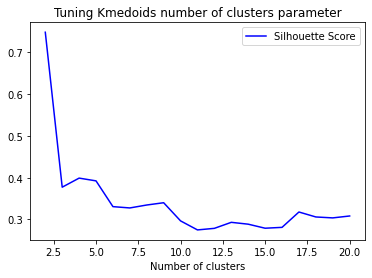

In [85]:
plt.plot(list(kmedoids_silhouette.keys()), list(kmedoids_silhouette.values()), color="blue", label="Silhouette Score")
plt.title("Tuning Kmedoids number of clusters parameter")
plt.xlabel("Number of clusters")
plt.legend(loc="upper right")
plt.show()

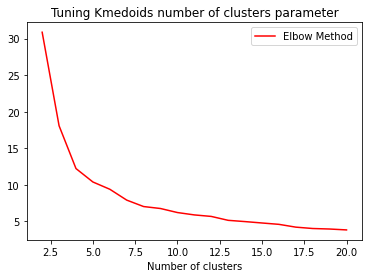

In [86]:
plt.plot(list(kmedoids_inertia.keys()), list(kmedoids_inertia.values()), color="red", label="Elbow Method")

plt.title("Tuning Kmedoids number of clusters parameter")
plt.xlabel("Number of clusters")
plt.legend(loc="upper right")
plt.show()

In [5]:
from sklearn_extra.cluster import KMedoids

n_clusters = 9
init = 'k-medoids++'
km_clustering = KMedoids(n_clusters=n_clusters, metric='cosine', init=init, max_iter=150, random_state=None).fit(reduced_embeddings)

km_clustering

KMedoids(init='k-medoids++', max_iter=150, metric='cosine', n_clusters=9)

In [14]:
data["label_kmedoids"] = km_clustering.labels_
print("cluster","members\n", data["label_kmedoids"].value_counts().sort_values())

cluster members
 1     112
5    1267
2    1320
8    1776
6    3050
7    3118
0    4090
4    5243
3    5938
Name: label_kmedoids, dtype: int64


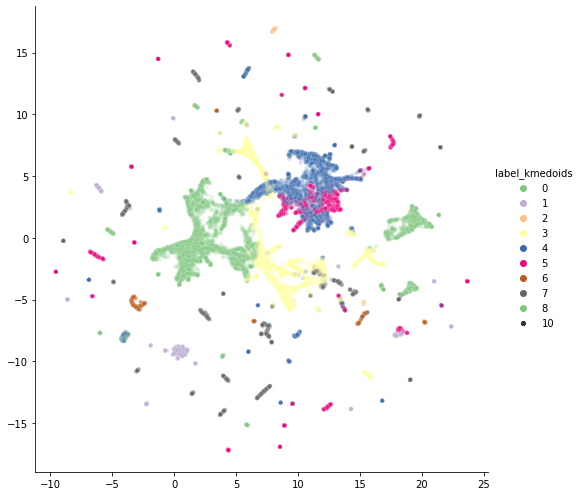

In [96]:
palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1], size = 10, hue = data["label_kmedoids"], palette = palette_param,alpha = alpha_param,height = 7)

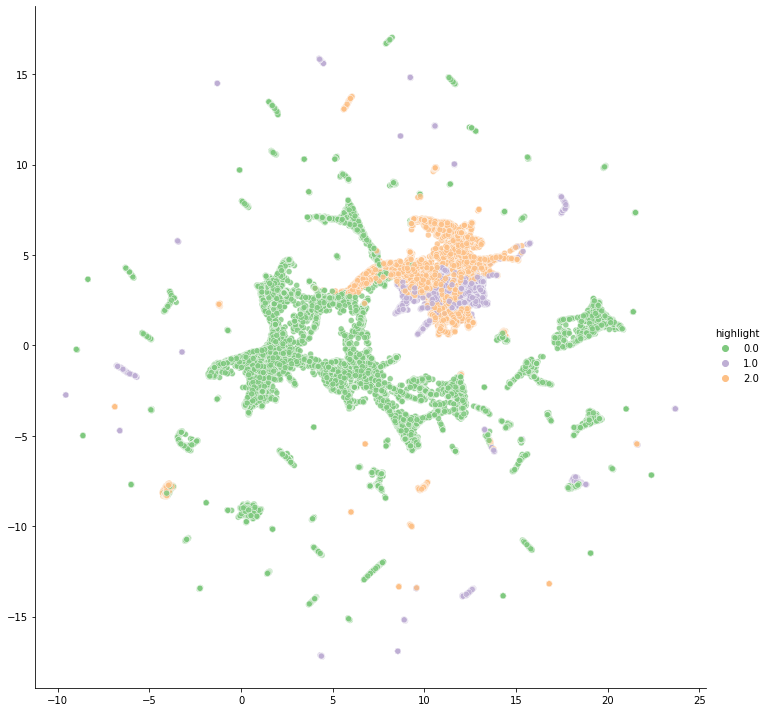

In [97]:
cluster_num = 5
cluster_num_2 = 4

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1
data.loc[data['label_kmedoids'] == cluster_num_2, 'highlight'] = 2

sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

In [100]:
# Choose a cluster to print
cluster_number = 5
# Choose the number of samples to print
number_of_samples_to_print = 1000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

print("Number of samples in the cluster:", cluster["text"].count())
cluster.head(100)

Number of samples in the cluster: 2830


,publishedAt,authorName,text,isReply,cleaned,labels_agglomerative,label_kmedoids,highlight
9,2020-01-14 11:04:06,Vietnam Ball,"If I was 100 years old, i'll be the first to d...",0,"If I was 100 years old, i'll be the first to d...",4,5,1.0
30,2020-01-07 21:12:09,Faruk ve Alper'in Vlog Dünyası,Türkey yaşıttoer 💉😍🇮🇶🇰🇷🇮🇲. (*\n\n,0,Türkey yaşıttoer 💉😍🇮🇶🇰🇷🇮🇲. (*\n\n,2,5,1.0
75,2019-12-28 23:59:30,Abraham Coffin,Subscribe to me at:\n\n\n,0,Subscribe to me at:\n\n\n,4,5,1.0
76,2019-12-28 23:58:31,Abraham Coffin,hey (hey)\n\n,0,hey (hey)\n\n,4,5,1.0
81,2019-12-28 15:44:29,MANGEKYO SHARINGAN,How about new Zealand?\n\n,0,How about new Zealand?\n\n,4,5,1.0
...,...,...,...,...,...,...,...,...
1041,2019-08-16 19:58:50,Im not a Rapper,I feel bad for iceland\n\n,0,I feel bad for iceland\n\n,4,5,1.0
1082,2019-08-13 23:01:07,Sanggook Kim,검색 해 보니 엄청난 내용 이내요. \nworld/the-global-emergen...,1,검색 해 보니 엄청난 내용 이내요. \nworld/the-global-emergen...,2,5,1.0
1085,2019-08-08 22:31:42,Keith Howard,More room for fish\n\n,0,More room for fish\n\n,4,5,1.0
1110,2019-08-05 14:02:32,Andre Zamora,Where is the Philippines\n\n,0,Where is the ippines\n\n,4,5,1.0


## Agglomerative Clustering

Recursively merges the pair of clusters that minimally increases a given linkage distance.

**Parameters:**
- Distance function
- Linkage-criterion: ward, single, average..
- Distance threshold
- linkage cannot be ward with cosine distance
- n of clusters must be None if distance_threshold is not None

Choosing distance threshold param with help of dendrogram and distance matrix.

**Experiments:**
- with distance_threshold 0.5, n_clusters None, euclidean distance, ward affinity: ~20000 clusters with max 14 members
- with distance_threshold 0,4,0.5, 0.6, n_clusters None, cosine distance, average affinity: 1 cluster
- NEXT: with n_clusters 9, method ward, euclidean distance

!!! Downstream tasks

Dendrogram suggests using ward method bc it reflects the structure of the data best

Silhouette score suggests using cosine and average bc it gives better score, but all scores lowwww

In [8]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

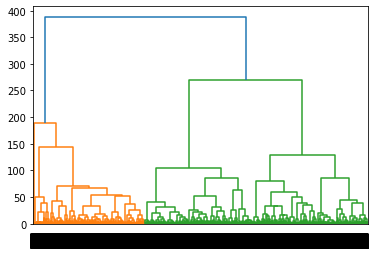

In [55]:
dendrogram = sch.dendrogram(sch.linkage(reduced_embeddings, method='ward'))

In [6]:
Z = sch.linkage(reduced_embeddings, 'ward')

In [7]:
Z_average = sch.linkage(reduced_embeddings, 'average')

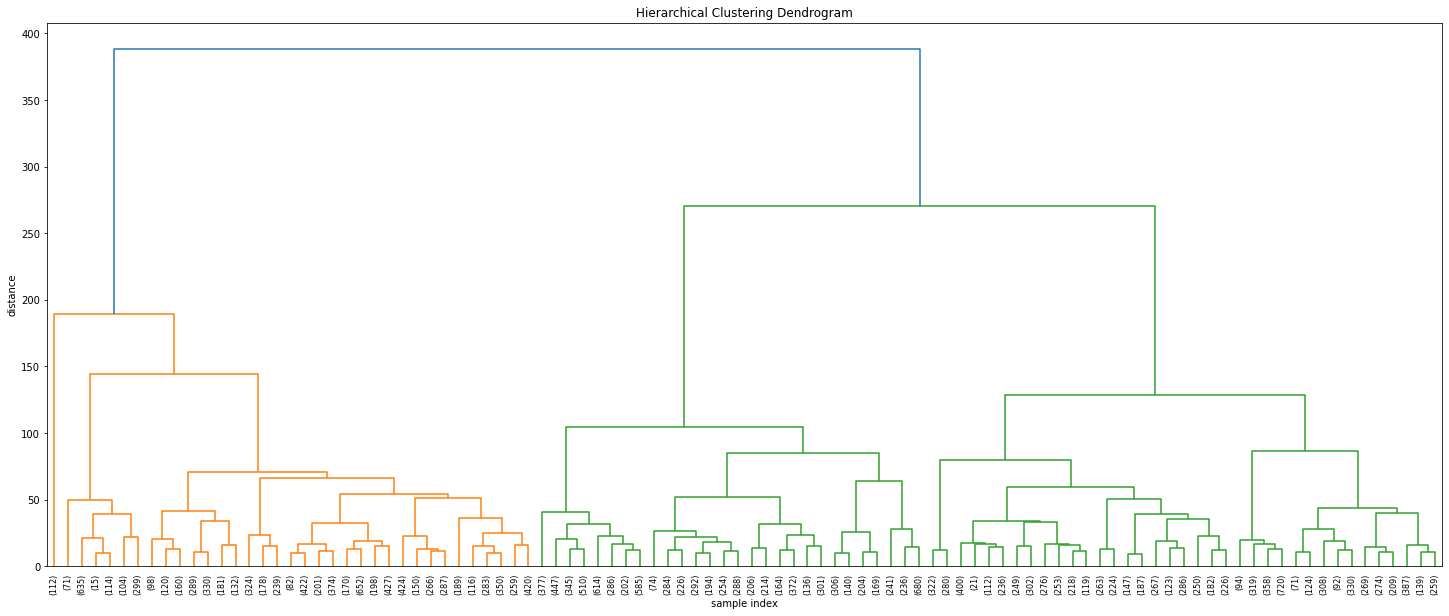

In [9]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sch.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score

s_scores_cos, freq_cos = {}, {}

for i in range(2,21):
    clustering = AgglomerativeClustering(
        distance_threshold=None,
        n_clusters=i,
        affinity='cosine',
        linkage='average'
    ).fit(reduced_embeddings)
    
    labels = clustering.labels_
    s_scores_cos[i] = silhouette_score(reduced_embeddings, labels)
    (unique, counts) = np.unique(labels, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    freq_cos[i]= frequencies[frequencies[:,0].argsort()]
    print("The silhouette score with {} clusters: {}".format(i, s_scores_cos[i]))

The silhouette score with 2 clusters: 0.7484121322631836
The silhouette score with 3 clusters: 0.5642737746238708
The silhouette score with 4 clusters: 0.35280653834342957
The silhouette score with 5 clusters: 0.3681146502494812
The silhouette score with 6 clusters: 0.3443331718444824
The silhouette score with 7 clusters: 0.34289097785949707
The silhouette score with 8 clusters: 0.30288615822792053
The silhouette score with 9 clusters: 0.2966131567955017
The silhouette score with 10 clusters: 0.31035611033439636
The silhouette score with 11 clusters: 0.3006002604961395
The silhouette score with 12 clusters: 0.3027747869491577
The silhouette score with 13 clusters: 0.30217960476875305
The silhouette score with 14 clusters: 0.294228732585907
The silhouette score with 15 clusters: 0.3111386001110077
The silhouette score with 16 clusters: 0.31826433539390564
The silhouette score with 17 clusters: 0.3128323256969452
The silhouette score with 18 clusters: 0.31049013137817383
The silhouette s

In [31]:
import operator
sorted(s_scores_cos.items(), key=operator.itemgetter(1), reverse=True)

[(2, 0.74841213),
 (3, 0.5642738),
 (5, 0.36811465),
 (4, 0.35280654),
 (6, 0.34433317),
 (7, 0.34289098),
 (16, 0.31826434),
 (19, 0.3181096),
 (17, 0.31283233),
 (15, 0.3111386),
 (18, 0.31049013),
 (10, 0.3103561),
 (8, 0.30288616),
 (12, 0.3027748),
 (13, 0.3021796),
 (11, 0.30060026),
 (9, 0.29661316),
 (14, 0.29422873)]

In [52]:
print("Cluster cardinality with 7 clusters \n{}".format(freq_cos[7]))
print("Cluster cardinality with 6 clusters \n{}".format(freq_cos[6]))


Cluster cardinality with 7 clusters 
[[   0 9178]
 [   1 8466]
 [   2 1234]
 [   3  112]
 [   4 6832]
 [   5   21]
 [   6   71]]
Cluster cardinality with 6 clusters 
[[   0 8066]
 [   1 9178]
 [   2   71]
 [   3  112]
 [   4 8466]
 [   5   21]]


In [23]:
from sklearn.metrics import silhouette_samples, silhouette_score

s_scores, freq = {}, {}

for i in range(2,21):
    clustering = AgglomerativeClustering(
        distance_threshold=None,
        n_clusters=i,
        affinity='euclidean',
        linkage='ward'
    ).fit(reduced_embeddings)
    
    labels = clustering.labels_
    s_scores[i] = silhouette_score(reduced_embeddings, labels)
    (unique, counts) = np.unique(labels, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    freq[i]= frequencies[frequencies[:,0].argsort()]

    print("The silhouette score with {} clusters: {}".format(i, s_scores[i]))

The silhouette score with 2 clusters: 0.36798036098480225
The silhouette score with 3 clusters: 0.3714355230331421
The silhouette score with 4 clusters: 0.38386476039886475
The silhouette score with 5 clusters: 0.37568220496177673
The silhouette score with 6 clusters: 0.3567632734775543
The silhouette score with 7 clusters: 0.3040723502635956
The silhouette score with 8 clusters: 0.2952265441417694
The silhouette score with 9 clusters: 0.3045317828655243
The silhouette score with 10 clusters: 0.32150936126708984
The silhouette score with 11 clusters: 0.2804258465766907
The silhouette score with 12 clusters: 0.28438469767570496
The silhouette score with 13 clusters: 0.28329092264175415
The silhouette score with 14 clusters: 0.2778021991252899
The silhouette score with 15 clusters: 0.2652517557144165
The silhouette score with 16 clusters: 0.26619213819503784
The silhouette score with 17 clusters: 0.2746417224407196
The silhouette score with 18 clusters: 0.28334686160087585
The silhouette

In [9]:
a_clustering = AgglomerativeClustering(
    distance_threshold=None,
    n_clusters=9,
    affinity='cosine',
    linkage='average'
).fit(reduced_embeddings)

In [27]:
labels = clustering.labels_
s_score = silhouette_score(reduced_embeddings, labels)

s_score

0.34062606

In [72]:
clustering.labels_

array([0, 4, 1, ..., 4, 1, 0])

In [15]:
(unique, counts) = np.unique(a_clustering.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
freq_chart= frequencies[frequencies[:,0].argsort()]

freq_chart

array([[   0, 7877],
       [   1, 6832],
       [   2, 1234],
       [   3,  589],
       [   4, 9104],
       [   5,   21],
       [   6,   71],
       [   7,   74],
       [   8,  112]])

In [10]:
data['labels_agglomerative'] = a_clustering.labels_

In [19]:
import umap 

n_neighbors = 30
min_dist = 0.1
n_components = 2

d2_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    metric='cosine'
).fit_transform(reduced_embeddings)

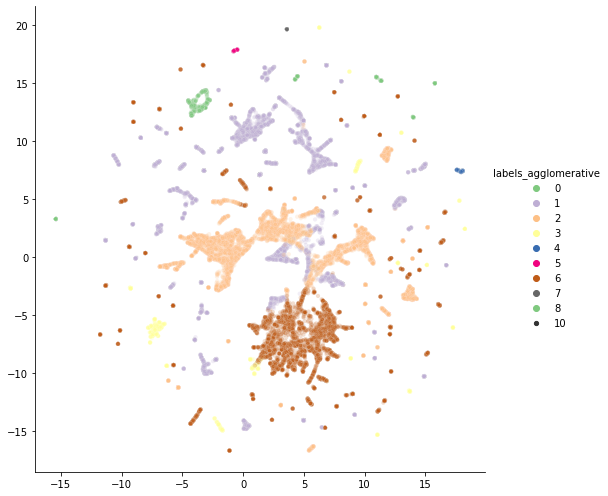

In [21]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1], size = 10, hue = data["labels_agglomerative"], palette = palette_param,alpha = alpha_param,height = 7)

In [83]:
# Choose a cluster to print
cluster_number = 2
# Choose the number of samples to print
number_of_samples_to_print = 1000

data['labels_agglomerative'] = data['labels_agglomerative'].astype('category')
cluster = data[data['labels_agglomerative']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

print("Number of samples in the cluster:", cluster["text"].count())
cluster.tail(100)

Number of samples in the cluster: 1234


,publishedAt,authorName,text,isReply,cleaned,labels_agglomerative
23797,2015-10-23 03:56:58,Dank Dank,Literally....\n\n,1,Literally....\n\n,2
23845,2015-10-29 22:01:18,Kattenelvis,+Matthew L *Incomming stream of refuges from t...,1,+hew L *Incomming stream of refuges from the c...,2
23852,2016-03-23 12:37:45,xanner999,@Sgopal20Donut ja :(\n\n,1,@ ja :(\n\n,2
23853,2016-03-23 09:52:08,Sgopal20Donut,Vi forsvinder....\n\n,1,Vi forsvinder....\n\n,2
23854,2016-03-20 12:07:02,Hareide Fan,@Alexander Balesini Great!\n\n,1,@ander Balesini Great!\n\n,2
...,...,...,...,...,...,...
25888,2015-04-03 21:28:29,La profe Myriam,@Stevon Robb\n\n,1,@\n\n,2
25890,2015-04-03 00:09:17,misaVR,www dot yellowmaps dot com/map/canada-relief-m...,1,www dot yellowmaps dot com/map/ca-relief-map-6...,2
25891,2015-04-02 23:54:45,Diana Martinez,Oooww :'(\n\n,1,Oooww :'(\n\n,2
25911,2015-04-02 19:51:29,Eknut .X,@metimoteo HAHAHA!!\n\n,1,@ HAHAHA!!\n\n,2


## Density-based clustering

### HDBSCAN

HDBSCAN extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. 

**Assumptions:** noisy data, clusters we would like to uncover

What actually happens? We can break it out into a series of steps:

1) Transform the space according to the density/sparsity.

2) Build the minimum spanning tree of the distance weighted graph.

3) Construct a cluster hierarchy of connected components.

4) Condense the cluster hierarchy based on minimum cluster size.

5) Extract the stable clusters from the condensed tree.

**Parameters:**

min_samples: larger values -> more data is labelled as noise

min_cluster_size: smallest group to be considered a cluster

cluster_selection_epsilon: eps from DBSCAN: max distance between two samples for them to be considered as in a neigborhood, default=0.5


!! Too many clusters to compare, clusters make sense in itself, noisy comments are not just comments that have one word
!! Setting min_cluster_size to any value: only one cluster, the rest noise

!! How is the utility good if it takes so much timmeee, hdbscan faster, worse performance on varying density https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html![image.png](attachment:image.png)

The most likely explanation is to do with the dimensionality of your input data. While HDBSCAN can perform well on low to medium dimensional data the performance tends to decrease significantly as dimension increases. In general HDBSCAN can do well on up to around 50 or 100 dimensional data, but performance can see significant decreases beyond that. Of course a lot is also dataset dependent, so you can still get good performance even on high dimensional data, but it is no longer guaranteed

In [53]:
import hdbscan

labels = hdbscan.HDBSCAN(
    min_cluster_size=60, min_samples=1, cluster_selection_method="leaf"
).fit_predict(reduced_embeddings)

In [41]:
import hdbscan

hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=60, min_samples=1
).fit(reduced_embeddings)

<AxesSubplot:ylabel='$\\lambda$ value'>

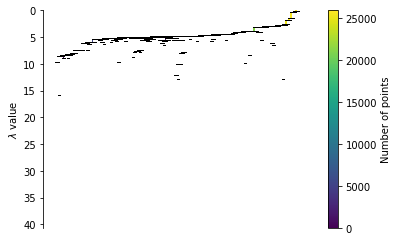

In [42]:
hdbscan.condensed_tree_.plot()

The HDBSCAN object now has an attribute (computed when first accessed) called outlier_scores_. This provides a numpy array with a value for each sample in the original dataset that was fit with the clusterer. The higher the score, the more likely the point is to be an outlier. In practice it is often best to look at the distributions of outlier scores.

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

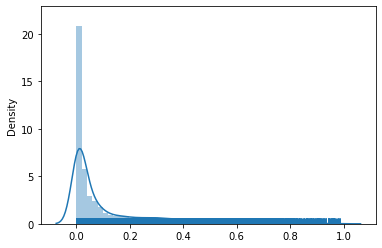

In [24]:
import seaborn as sns

sns.distplot(hdbscan.outlier_scores_[np.isfinite(hdbscan.outlier_scores_)], rug=True)

In [51]:
data['labels_hdbscan'] = labels

In [52]:
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies_chart= frequencies[frequencies[:,0].argsort()]

frequencies_chart

array([[   -1, 10130],
       [    0,   112],
       [    1,    71],
       [    2,    74],
       [    3,    83],
       [    4,    77],
       [    5,   174],
       [    6,   593],
       [    7,   206],
       [    8,   258],
       [    9,   193],
       [   10,    85],
       [   11,   184],
       [   12,   248],
       [   13,   122],
       [   14,    62],
       [   15,   165],
       [   16,   185],
       [   17,   147],
       [   18,    92],
       [   19,    82],
       [   20,   117],
       [   21,   335],
       [   22,    61],
       [   23,    84],
       [   24,   104],
       [   25,    90],
       [   26,    89],
       [   27,   126],
       [   28,    67],
       [   29,   212],
       [   30,   186],
       [   31,    94],
       [   32,   264],
       [   33,    65],
       [   34,    70],
       [   35,   115],
       [   36,   131],
       [   37,    73],
       [   38,    74],
       [   39,   123],
       [   40,   113],
       [   41,   103],
       [   

<BarContainer object of 93 artists>

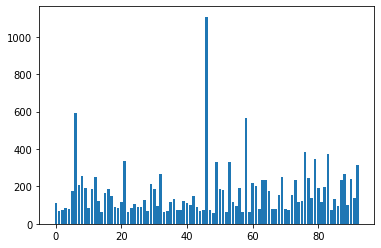

In [46]:
import matplotlib.pyplot as plt

plt.bar(frequencies[1:,0], frequencies[1:,1]) #excluding noise

In [47]:
n_neighbors = 50
min_dist = 0.1
n_components = 2

d2_embeddings = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(reduced_embeddings)

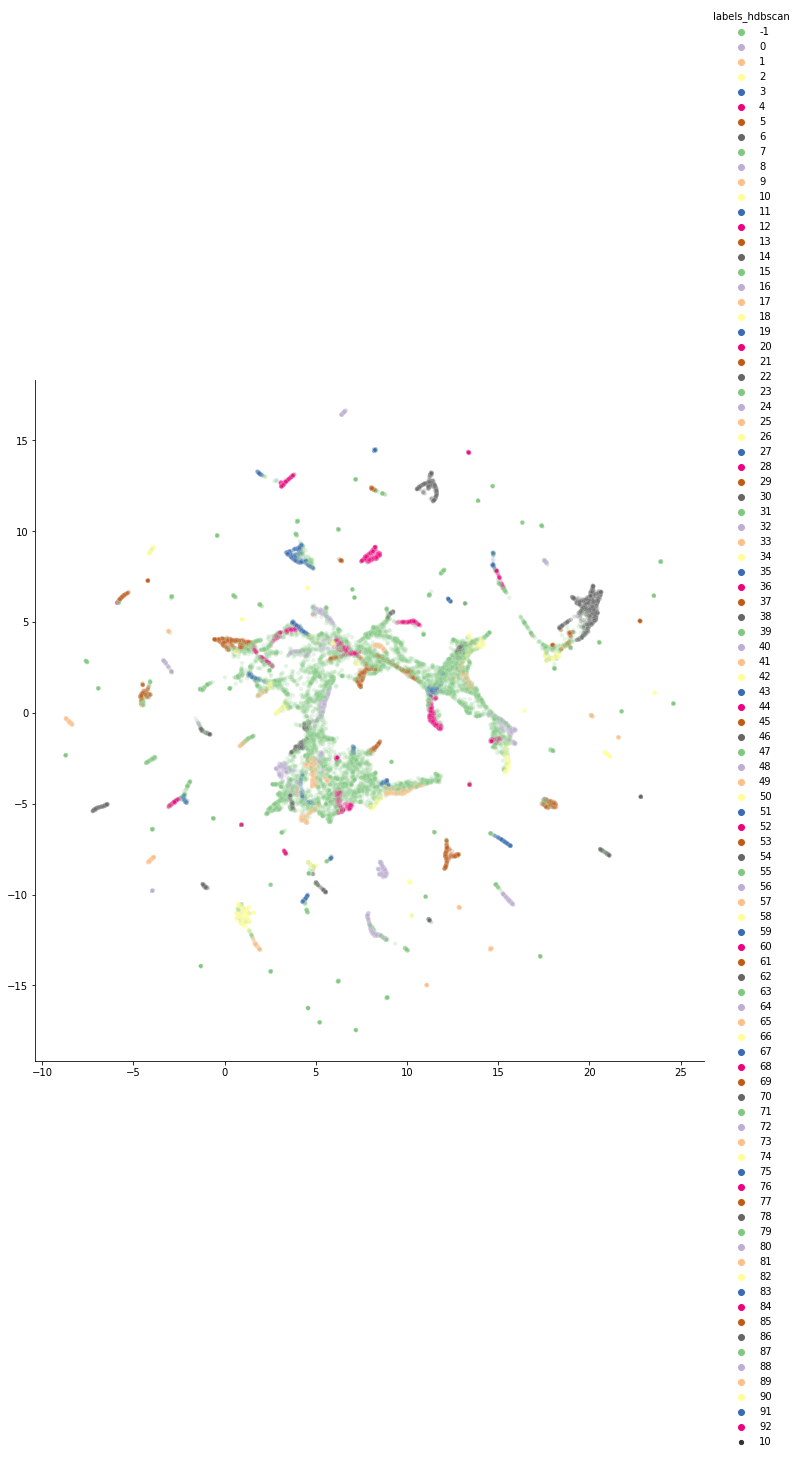

In [48]:
import seaborn as sns

palette_param = "Accent"
alpha_param = 0.2


sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1], size = 10, hue = data["labels_hdbscan"], palette = palette_param,alpha = alpha_param,height = 10)

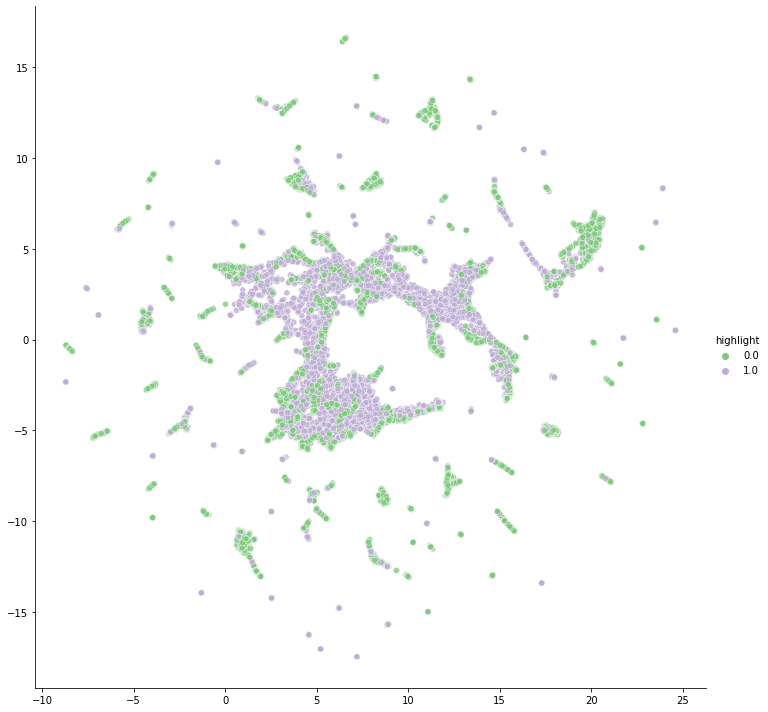

In [49]:
cluster_num = -1
data['highlight'] = np.zeros(len(data.index))
data.loc[data['labels_hdbscan'] == cluster_num, 'highlight'] = 1

sns.relplot(x = d2_embeddings[:, 0], y = d2_embeddings[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

In [50]:
# Choose a cluster to print
cluster_number = -1
# Choose the number of samples to print
number_of_samples_to_print = 1000

data['labels_hdbscan'] = data['labels_hdbscan'].astype('category')
cluster = data[data['labels_hdbscan']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

print("Number of samples in the cluster:", cluster["text"].count())
cluster

Number of samples in the cluster: 10130


,publishedAt,authorName,text,isReply,cleaned,labels_hdbscan,highlight
0,2020-01-16 09:01:08,Lee McLellan,If all the ice melts surely the tilt of the ea...,0,If all the ice melts surely the tilt of the ea...,-1,1.0
3,2020-01-15 08:35:50,Shane Meyer,Step #1: Taxes... Step #2: ???... Step #3: Uto...,0,Step #1: Taxes... Step #2: ???... Step #3: Uto...,-1,1.0
4,2020-01-15 02:00:30,Rennie Allen,Strange how Hudson's Bay stayed the same size....,0,Strange how Hudson's Bay stayed the same size....,-1,1.0
6,2020-01-14 20:21:36,Josué Oller,Brazil will lost 25% of territory 😂\n\n,0,will lost 25% of territory 😂\n\n,-1,1.0
8,2020-01-14 13:02:13,Peter Vaichus,If this was an actual concern...at all...then ...,0,If this was an actual concern...at all...then ...,-1,1.0
...,...,...,...,...,...,...,...
25906,2015-04-29 23:32:58,CaptainCannonman,Are you fucking kidding me right now?? America...,1,Are you fucking kidding me right now?? ns (som...,-1,1.0
25910,2015-04-03 00:11:16,Gabriel Estéban Muñoz,@Eknut .X Or South America\n\n,1,@ Or \n\n,-1,1.0
25913,2015-03-01 20:21:57,Senso Rieskin,And tought it would be a big deal. Plenty land...,0,And tought it would be a big deal. Plenty land...,-1,1.0
25915,2015-02-26 01:51:39,rarier,Yay!! Valdosta sinks and my farm becomes expen...,0,Yay!! Valdosta sinks and my farm becomes expen...,-1,1.0
